In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [2]:
import utils.metrics as utils_metrics

In [3]:
import hashlib

In [4]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [5]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [6]:
def reproducible_hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])

    text, text_rate = max(texts.items(),
                          key=lambda x: (
                              x[1],
                              x[0] != "",
                              -x[0].count('?'),
                              reproducible_hash(x[0])  # for reproducible behavior
                          ))
    if text_rate >= 2:  # and text != "":
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    return AggregationResult(text, conf, cost)

In [7]:
evaluate_metrics = utils_metrics.evaluate_metrics_for_algorithm

In [8]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [9]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [10]:
# Prod baseline
prod_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod)

Recall: 87.6792%
WER: 13.2758%
Mean overlap: 3.833


In [11]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [12]:
aggregate_rover_with_clf_

<function __main__.aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None, preaggregated=None)>

In [13]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return utils_metrics.evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              0,
                                              cluster_refernces, 
                                              print_)

In [14]:
import matplotlib.pyplot as plt

In [15]:
import pickle

In [16]:
with open('../notebooks/pickled/preaggregated_assistant_with_solo_assistant_question.pickle', 'rb') as f:
    preaggregated = pickle.load(f)
len(preaggregated)

3486

In [17]:
import seaborn as sns
sns.set(style="whitegrid")

In [19]:
def aggregate_rover_with_clf_by_word(rows, features, field_name, clf, threshold_by_word=0.9, treshhold=0.94,
                                     min_cost=3, max_cost=10, cluster_references=None, preaggregated=None):
    """
       experiments with question sign exchange
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    changed_signs_in_aggregated = 0
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost:
                continue
            score = sum(score for value, score in item1) / len(item1)
#             scores = sorted([(value, score) for value, score in item1], key=lambda x: x[1])
#             score = scores[-1][1]
            tokens = [value for value, score_ in item1 if value != ""]
            tokens = []
            prev_question = False
            for value, score_ in item1:
                if score_ > threshold_by_word and value != "" and value != "?":
                    tokens.append(value)
                    prev_question = False
                elif not prev_question and value != "":
                    tokens.append("?")
                    changed_signs_in_aggregated += 1
                    prev_question = True
            text = " ".join(tokens)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                conf = score
                if text == '?' or (text == '' and score < treshhold):
                    text = None
                results[task_id] = AggregationResult(text, conf, cost)
                break
    # print("Number of changed \'?\': {}".format(changed_signs_in_aggregated))
    return results

In [20]:
preaggregated['1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus']

{1: [('', 0.6846747656650313)],
 2: [('', 0.8797422806822525)],
 3: [('', 0.935914017338639)],
 4: [('', 0.9476157703498646)],
 5: [('', 0.9642552025849801)],
 6: [('', 0.9860052903329602)],
 7: [('', 0.9829542698996759)],
 8: [('', 0.9819593114274828)],
 9: [('', 0.9882454214427111)],
 10: [('', 0.9902087289873817)]}

In [21]:
res_with_words = aggregate_rover_with_clf_by_word(valid_rows, 
                                 {},
                                 'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                 None, 
                                 threshold_by_word=0.8210526315789474,
                                 treshhold=0.948,
                                 min_cost=3,
                                 max_cost=7,
                                 preaggregated=preaggregated)

In [22]:
pd.DataFrame(list(res_with_words.values())).sample(20)

,text,confidence,cost
3042,давай приходи,0.989892,3
3229,как выглядит флаг италии,0.961158,3
2771,,0.970673,3
2185,привет алиса,0.961605,6
1258,а как зовут твою маму,0.991830,3
262,,0.965000,3
1794,так поздоровайся нормально скажи здравствуйте,0.992484,3
2314,привет,0.950610,3
3265,это еще почему,0.990007,3
1876,,0.968053,4


In [23]:
conf_0 = 0
for key, value in res_with_words.items():
    if value.confidence == 0:
        conf_0 += 1
conf_0 / len(res_with_words)

0.0

In [24]:
from functools import partial

In [25]:
from collections import defaultdict

In [26]:
threshhold = 0.948
evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_, 
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated))

Recall: 85.6099%
WER: 6.8220%
Mean overlap: 4.001


(0.8560986032503954, 0.06822048315753658, 4.0014343086632245)

In [49]:
scores_clf_score_by_word_q_mean_v3 = defaultdict(list)

for threshhold in [0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]: # np.linspace(0.89, 0.95, 10):
    print('\n' + str(threshhold))
    for th_by_word in np.linspace(0.5, 0.9, 21):
        if threshhold == 1 and th_by_word == 1:
            continue
        print(th_by_word)
        metrics = evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                           threshold_by_word=th_by_word,
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated))
        if metrics[0] < baseline_loaded_new_metrics[1]:
            break
        if metrics[0] >= baseline_loaded_new_metrics[1] and metrics[1] < baseline_loaded_new_metrics[2]:
            scores_clf_score_by_word_q_mean_v3[threshhold].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean_v3[threshhold] = np.array(scores_clf_score_by_word_q_mean_v3[threshhold])


0.85
0.5
Recall: 91.5728%
WER: 11.8539%
Mean overlap: 3.139
0.52
Recall: 91.4685%
WER: 11.8236%
Mean overlap: 3.139
0.54
Recall: 91.1239%
WER: 11.7162%
Mean overlap: 3.139
0.56
Recall: 90.8714%
WER: 11.6525%
Mean overlap: 3.139
0.58
Recall: 90.6502%
WER: 11.5043%
Mean overlap: 3.139
0.6
Recall: 90.2988%
WER: 11.3729%
Mean overlap: 3.139
0.62
Recall: 90.0348%
WER: 11.2658%
Mean overlap: 3.139
0.64
Recall: 89.7500%
WER: 11.1634%
Mean overlap: 3.139
0.66
Recall: 89.3399%
WER: 10.9387%
Mean overlap: 3.139
0.6799999999999999
Recall: 88.8497%
WER: 10.7053%
Mean overlap: 3.139
0.7
Recall: 88.5208%
WER: 10.5158%
Mean overlap: 3.139
0.72
Recall: 88.1129%
WER: 10.3246%
Mean overlap: 3.139
0.74
Recall: 87.6560%
WER: 10.1503%
Mean overlap: 3.139
0.76
Recall: 86.9804%
WER: 9.9431%
Mean overlap: 3.139
0.78
Recall: 86.0802%
WER: 9.5377%
Mean overlap: 3.139
0.8
Recall: 85.1110%
WER: 9.2262%
Mean overlap: 3.139

0.86
0.5
Recall: 91.6636%
WER: 11.7102%
Mean overlap: 3.174
0.52
Recall: 91.5593%
WER: 11.

Recall: 91.6340%
WER: 9.7073%
Mean overlap: 3.676
0.64
Recall: 91.2681%
WER: 9.6318%
Mean overlap: 3.676
0.66
Recall: 90.8320%
WER: 9.4812%
Mean overlap: 3.676
0.6799999999999999
Recall: 90.4193%
WER: 9.3964%
Mean overlap: 3.676
0.7
Recall: 90.0898%
WER: 9.2110%
Mean overlap: 3.676
0.72
Recall: 89.6648%
WER: 9.0763%
Mean overlap: 3.676
0.74
Recall: 89.2149%
WER: 8.9062%
Mean overlap: 3.676
0.76
Recall: 88.6960%
WER: 8.7719%
Mean overlap: 3.676
0.78
Recall: 88.0479%
WER: 8.5265%
Mean overlap: 3.676
0.8
Recall: 87.0939%
WER: 8.2988%
Mean overlap: 3.676
0.8200000000000001
Recall: 85.9795%
WER: 8.0291%
Mean overlap: 3.676
0.8400000000000001
Recall: 84.4772%
WER: 7.6874%
Mean overlap: 3.676

0.94
0.5
Recall: 93.0184%
WER: 10.0045%
Mean overlap: 3.835
0.52
Recall: 92.8412%
WER: 9.9448%
Mean overlap: 3.835
0.54
Recall: 92.6428%
WER: 9.8192%
Mean overlap: 3.835
0.56
Recall: 92.4743%
WER: 9.6847%
Mean overlap: 3.835
0.58
Recall: 92.1463%
WER: 9.4887%
Mean overlap: 3.835
0.6
Recall: 91.8362%
WER

In [50]:
with open('../notebooks/pickled/base_line_new_metrics_solo_assistant.pickle', 'rb') as f:
    baseline_loaded_new_metrics = pickle.load(f)
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

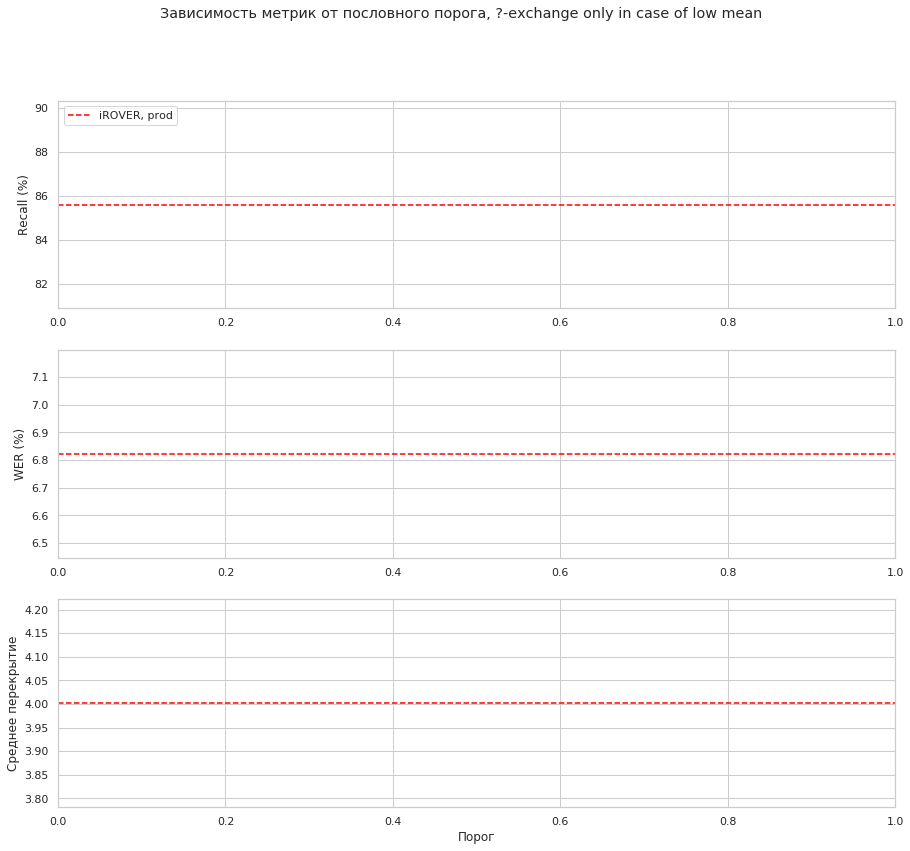

In [51]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    if len(value):
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label='{:.3f}'.format(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    if len(value):
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    if len(value):
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.show()

In [214]:
scores_clf_score_by_word_q_mean_v3[0.948][15]

array([0.975     , 0.86586285, 0.06766235, 4.00143431])

In [215]:
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])